In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import fire 
from tqdm import tqdm

from models import load_model
from utils import load_config, get_logger


class SyntheticGenerator():
    def __init__(self, pretrained_model, data_config, device, logger, size, iterations=1000):

        self.model = pretrained_model
        self.size = size
        self.device = device

        self.logger = logger
        self.iterations = iterations
        self.data_config = data_config

        self.model.eval()
        self.model.to(self.device)

        self.size_per_label = self.size // self.data_config["num_classes"]

        t_mean = self.data_config["mean"]
        t_std = self.data_config["std"]

        self.transform = transforms.Compose([
            transforms.Resize(self.data_config["input_shape"][1:]),
            transforms.ToTensor(),
            transforms.Normalize(mean = t_mean, std = t_std)
        ])


    def generate_dataset(self):

        data = []
        data_labels = []
        num_labls = self.data_config["num_classes"]
        batch_size = self.size // num_labls

        self.logger.print(f"required to generate {self.size} number of images")
        self.logger.print(f"generating {batch_size} images for each of the {num_labls} labels")
        
        for label in tqdm(range(num_labls)):
            self.logger.print(f"Generating images for label {label}")


            image_batch = self.generate_batch(label, batch_size)
            data.append(image_batch)
            data_labels.append(torch.full((batch_size,), label, dtype=torch.long))

        data = torch.cat(data)
        data_labels = torch.cat(data_labels)

        print(f"The shape of the generated dataset is {data.shape} and labels is {data_labels.shape}")

        dataloader = DataLoader(TensorDataset(data, data_labels), shuffle=True)
        return dataloader
    

    def generate_batch(self, label, batch_size):

        image = self.random_image(batch_size).to(self.device)
        image.requires_grad = True
        optimizer = optim.Adam([image], lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

        # for _ in range(self.iterations):
        self.logger.print(f"Generating a batch of {batch_size} images")
        for _ in tqdm(range(self.iterations)):
            optimizer.zero_grad()
            output = self.model(image)
            class_loss = -output[:, label].sum()

            # regularization to make the images more visisble
            l2_loss = 0.001 * torch.norm(image)
            tv_loss = 0.001 * (torch.sum(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) +
                               torch.sum(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :])))
            
            loss = class_loss + l2_loss + tv_loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            with torch.no_grad():
                image.clamp_(0, 1)  # gradient clipping for stable generation

        return image.detach()

    def random_image(self, batch_size):
        # setting the initial value of the random image to be close to the dataset distribution
        random_image = torch.randn(batch_size, *self.data_config["input_shape"], device=self.device)
        
        mean = torch.tensor(self.data_config["mean"]).view(1, -1, 1, 1).to(self.device)
        std = torch.tensor(self.data_config["std"]).view(1, -1, 1, 1).to(self.device)

        random_image = random_image * std + mean
        return random_image


In [6]:

def visualize_image(input_image: torch.Tensor):
    input_image = input_image.cpu().detach().numpy()

    num_channels = input_image.shape[0]
    if num_channels == 1:
        plt.imshow(np.transpose(input_image, (1, 2, 0))[:, :, 0], cmap="gray")

    elif num_channels == 3:
        plt.imshow(np.transpose(input_image, (1, 2, 0)))

    else: 
        raise ValueError("Input image must have 1 or 3 channels.")

    plt.show()


def generate( model_config: str, dataset_config: str, size: int, device: str = "cuda", name: str = None):

    model_config = load_config(model_config)
    dataset_config = load_config(dataset_config)
    device = torch.device(device)
    logger = get_logger()

    logger.print("Loading model")
    model, trained = load_model(model_config, torch.device("cuda"))
    logger.print(f"Model {model_config['model']} loaded, with trained status {trained}")
    
    if not trained:
        raise ValueError("Model must be trained.")

    generator = SyntheticGenerator(model, dataset_config, device, logger, size)
    # assert(0)
    dataloader = generator.generate_dataset()

    return dataloader


In [8]:
config1 = {

"model_config": "configs/model_configs/ResNet101_MNIST.yaml",
"dataset_config": "configs/dataset_configs/MNIST.yaml",
"device": "cuda",
"size": 100,
"output_dir": "data/synthetic",
"save_to_dir": False,

}



In [9]:
vis = 10

data_loader2 = generate( model_config= config1["model_config"],
                        dataset_config=config1["dataset_config"],
                        size=config1["size"],
                        device=config1["device"],
                     )  



# randomly visualize {vis} images


Loading model



/home/bini/anaconda3/envs/augcon/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bini/anaconda3/envs/augcon/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model build as resnet101, pretrained: True, output channels: 10
Loading model from ./trained_models/ResNet101_MNIST.pth
Model loaded from ./trained_models/ResNet101_MNIST.pth

Model ResNet101 loaded, with trained status True


required to generate 100 number of images


generating 10 images for each of the 10 labels



  0%|          | 0/10 [00:00<?, ?it/s]


Generating images for label 0


Generating 1 batch of images 10



 10%|█         | 1/10 [00:39<05:59, 39.95s/it]


Generating images for label 1


Generating 1 batch of images 10



 20%|██        | 2/10 [01:15<04:59, 37.44s/it]


Generating images for label 2


Generating 1 batch of images 10



 30%|███       | 3/10 [01:51<04:16, 36.62s/it]


Generating images for label 3


Generating 1 batch of images 10



 40%|████      | 4/10 [02:27<03:39, 36.56s/it]


Generating images for label 4


Generating 1 batch of images 10



 50%|█████     | 5/10 [03:03<03:01, 36.26s/it]


Generating images for label 5


Generating 1 batch of images 10



 60%|██████    | 6/10 [03:39<02:24, 36.23s/it]


Generating images for label 6


Generating 1 batch of images 10



 70%|███████   | 7/10 [04:16<01:48, 36.28s/it]


Generating images for label 7


Generating 1 batch of images 10



 80%|████████  | 8/10 [04:51<01:12, 36.14s/it]


Generating images for label 8


Generating 1 batch of images 10



 90%|█████████ | 9/10 [05:29<00:36, 36.47s/it]


Generating images for label 9


Generating 1 batch of images 10



100%|██████████| 10/10 [06:07<00:00, 36.71s/it]

The shape of the generated dataset is torch.Size([100, 1, 28, 28]) and labels is torch.Size([100])


In [22]:
x_gen = data_loader2.dataset.tensors[0]
labels = data_loader2.dataset.tensors[1]

x_all = torch.cat([ x_gen], dim=0)
x_all.shape, x_gen.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100, 1, 28, 28]))

In [32]:
# for i, (images, labels) in enumerate(data_loader2):
#     print(images.shape), print(labels.shape)
#     if i == vis:
# tensor_data, labels = data_loader2.dataset.tensors


from torchvision.utils import save_image, make_grid


def generate_save(generator, num_sampling):

    for i in range(num_sampling):

        data_loader = data_loader2

        x_gen, x_gen_store = data_loader.dataset.tensors
        x_all = torch.cat([x_gen])
        x_all = torch.clamp(x_all, min=-1.00, max=1.00)

        np.savez(f'./data/synthetic/MNIST/ACTIVATION/{i+3}_of_{num_sampling}.npz', data=x_all.cpu().detach().numpy())
        grid = make_grid(x_all*-1 + 1, nrow=25)
        save_image(grid,  f"./data/synthetic/MNIST/ACTIVATION/{i+1}_of_{num_sampling}.png")
        print('saved image at ' + f"./data/synthetic/MNIST/ACTIVATION/{i+1}_of_{num_sampling}.npz")

    return data_loader

generate_save(data_loader2, 1)

# i = 0
# num_sampling = 1

# x_gen, x_gen_store = data_loader2.dataset.tensors
# x_all = torch.cat([x_gen])
# x_all = torch.clamp(x_all, min=-1.00, max=1.00)

# np.savez(f'./data/synthetic/MNIST/ACTIVATION/{i+1}_of_{num_sampling}.npz', data=x_all.cpu().detach().numpy())
# grid = make_grid(x_all*-1 + 1, nrow=25)
# save_image(grid,  f"./data/synthetic/MNIST/ACTIVATION/{i+1}_of_{num_sampling}.png")
# print('saved image at ' + f"./data/synthetic/MNIST/ACTIVATION/{i+1}_of_{num_sampling}.npz")


saved image at ./data/synthetic/MNIST/ACTIVATION/1_of_1.npz


In [34]:
# laod he saved image

data_loaded = np.load("data/synthetic/MNIST/ACTIVATION/1_of_12.npz")

# get the shape
data_loaded['data'].shape

(1000, 1, 28, 28)

Label:  5 Shape:  torch.Size([1, 28, 28])


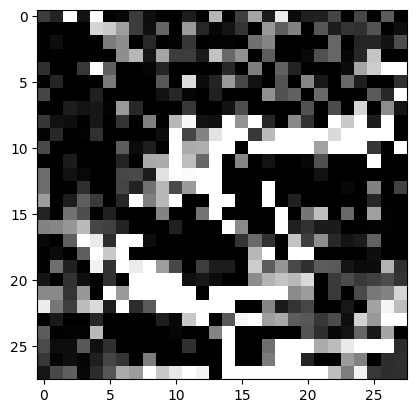

Label:  8 Shape:  torch.Size([1, 28, 28])


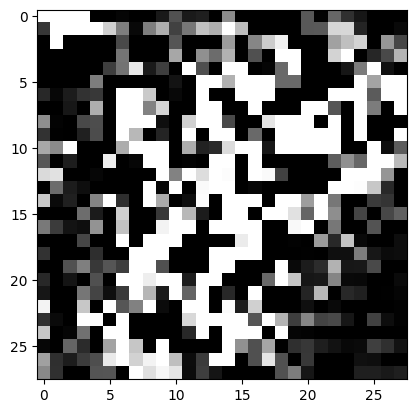

Label:  1 Shape:  torch.Size([1, 28, 28])


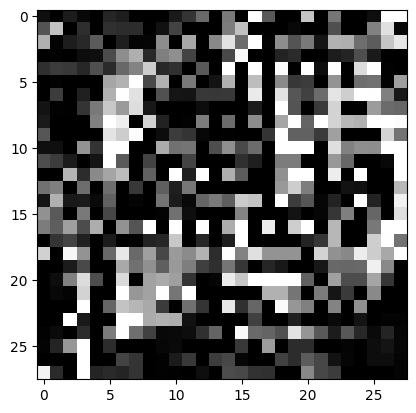

Label:  8 Shape:  torch.Size([1, 28, 28])


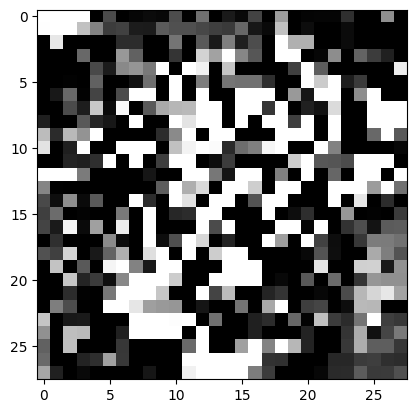

Label:  0 Shape:  torch.Size([1, 28, 28])


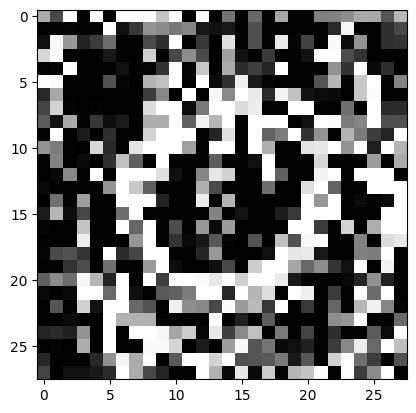

Label:  3 Shape:  torch.Size([1, 28, 28])


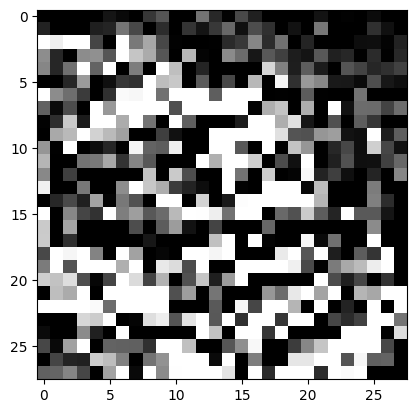

Label:  5 Shape:  torch.Size([1, 28, 28])


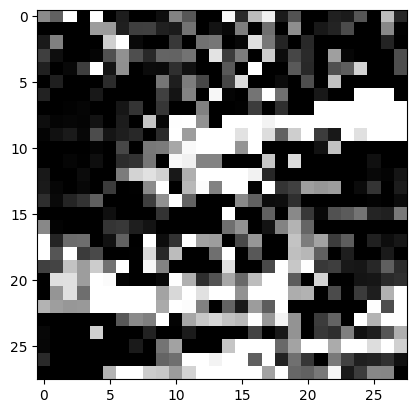

Label:  9 Shape:  torch.Size([1, 28, 28])


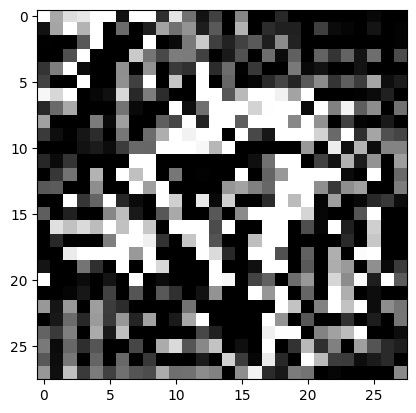

Label:  8 Shape:  torch.Size([1, 28, 28])


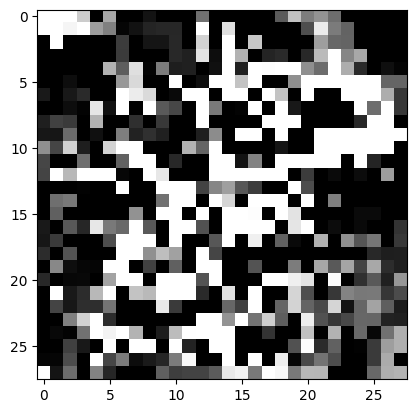

Label:  8 Shape:  torch.Size([1, 28, 28])


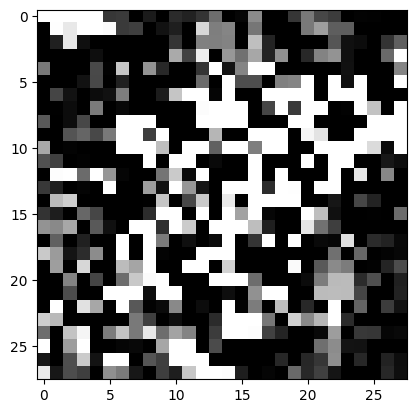

In [13]:
for i in range(vis):
    image, label = next(iter(data_loader2))
    print("Label: ", label[0].item(), "Shape: ", image[0].shape)
    visualize_image(image[0])
    

# output_dir=config["output_dir"]
# save_to_dir=config["save_to_dir"]
# if True:
#     if not name:
        
#         dataset_name = dataset_config["name"]
#         name = f"{dataset_name}_synthetic_{size}"

#     torch.save(dataloader, f"{output_dir}/{name}.pt")

Label:  9 Shape:  torch.Size([1, 28, 28])


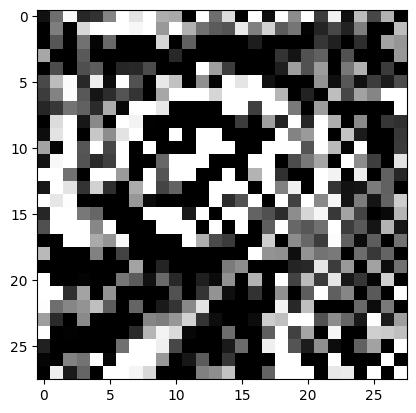

Label:  8 Shape:  torch.Size([1, 28, 28])


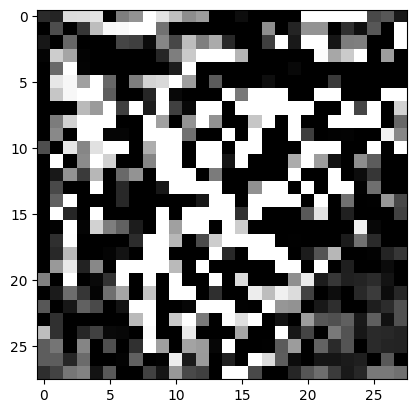

Label:  8 Shape:  torch.Size([1, 28, 28])


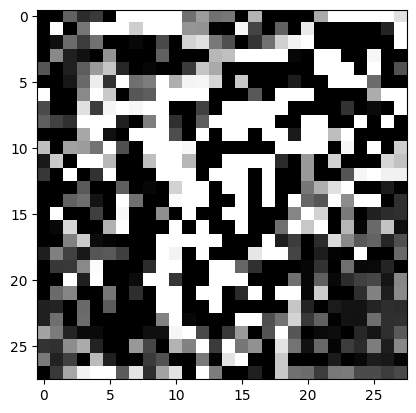

Label:  8 Shape:  torch.Size([1, 28, 28])


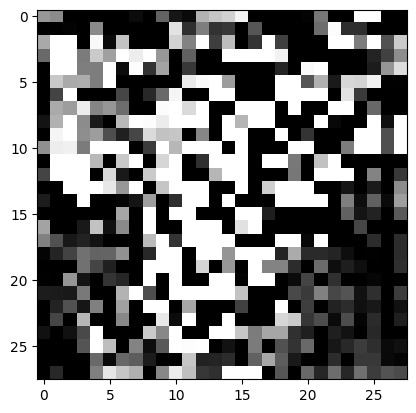

Label:  8 Shape:  torch.Size([1, 28, 28])


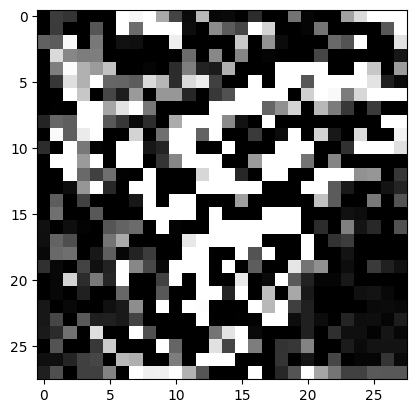

Label:  6 Shape:  torch.Size([1, 28, 28])


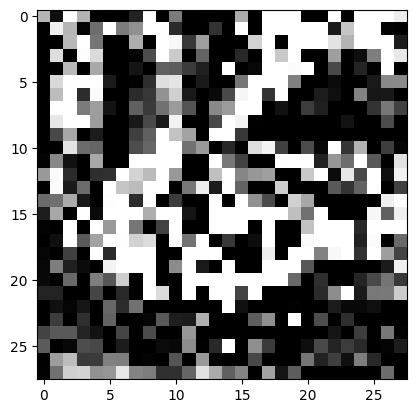

Label:  2 Shape:  torch.Size([1, 28, 28])


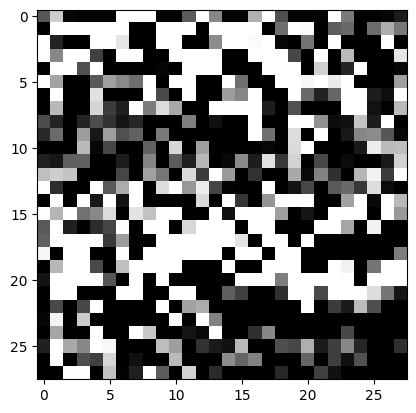

Label:  7 Shape:  torch.Size([1, 28, 28])


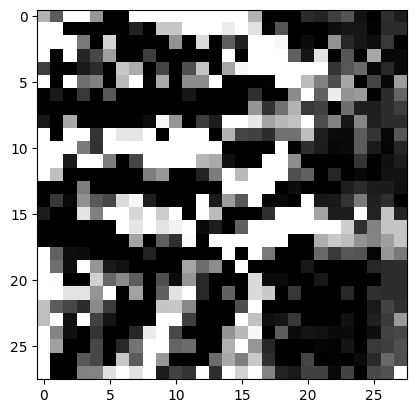

Label:  7 Shape:  torch.Size([1, 28, 28])


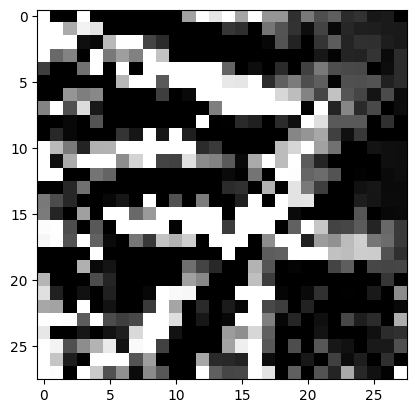

Label:  3 Shape:  torch.Size([1, 28, 28])


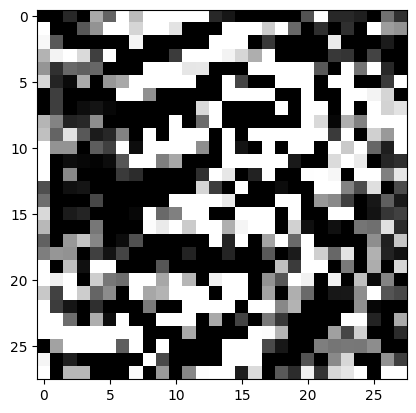

In [29]:
for i in range(vis):
    image, label = next(iter(data_loader))
    print("Label: ", label[0].item(), "Shape: ", image[0].shape)
    visualize_image(image[0])

In [48]:
# for usage
checkpoint_path = 'trained_models/ResNet18_MNIST.pth'
image_path = ''
target_layer = 2
resulting_image = activation_maximization(checkpoint_path, image_path, target_layer)

/home/bini/anaconda3/envs/augcon/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bini/anaconda3/envs/augcon/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AttributeError: 'str' object has no attribute 'read'

In [36]:
# generating synthetic dataset using activation maximization for each output class of the given model

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from PIL import Image

from models import load_model
from utils import load_config
import matplotlib.pyplot as plt


class SyntheticGenerator():
    def __init__(self, pretrained_model, data_config, device, logger, size_per_class, iterations=1000):

        self.model = pretrained_model
        self.size = size_per_class
        self.device = device
        
        self.logger = logger
        self.iterations = iterations
        self.data_config = data_config

        print(self.data_config["input_shape"])
        self.transform = transforms.Compose([
            transforms.Resize(self.data_config["input_shape"][1:]),
            transforms.ToTensor()
        ])

        self.model.eval()
        self.model.to(self.device)
        """ convert the activation function of the final layer of the model from softmax to linear """
        



    def generate_dataset(self,  batch_size = 64,output_dir = None):

        data = []
        data_labels = []
        dataloader = None

        for _ in range(self.size):
            for label in range(self.data_config["num_classes"]):

                gen_img = self.generate_batch(label, batch_size)
                data.append(gen_img)
                data_labels.append(label)

        # data = torch.stack(data) 
        # change the shape of the data from labels x batch x img_shape  to
        data_labels = torch.tensor(data_labels)

        dataloader = DataLoader(TensorDataset(data, data_labels), batch_size= batch_size, shuffle=True)

        if output_dir:
            print("Saving dataset to ", output_dir)
            torch.save(dataloader, output_dir)

        return dataloader


    def generate_batch(self, label, batch_size):

        image = self.random_image(batch_size).to(self.device)
        image.requires_grad = True

        optimizer = optim.Adam([image], lr=0.01)

        for _ in range(self.iterations):

            optimizer.zero_grad()
            output = self.model(image)
            loss = -output[0][label]
            loss.backward()
            optimizer.step()

        return image


    def random_image(self, batch_size = 64):

        random_high, random_low = 180, 160

        mean=torch.tensor([0.485]).unsqueeze(0).unsqueeze(2).unsqueeze(3)
        std=torch.tensor([0.229]).unsqueeze(0).unsqueeze(2).unsqueeze(3)

        random_high, random_low = 180, 160

        random_image = torch.rand(batch_size, *self.data_config["input_shape"])

        print(f"the shape of the generated image is {random_image.shape}")
        
        random_image = (((random_high - random_low) * random_image + random_low)/255)
        random_image = (random_image - mean) / std


        return random_image

def visualize_image(input_image: torch.Tensor):
    """given a torch tensor of shape [1, 28, 28] visualize an image of the MNIST dataset"""

    input_image = input_image.cpu().detach().numpy().squeeze()
    plt.imshow(input_image, cmap='gray')
    plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from models import load_model
from utils import load_config

class SyntheticGenerator():
    def __init__(self, pretrained_model, data_config, device, logger, size_per_class, iterations=1000):
        self.model = pretrained_model
        self.size = size_per_class
        self.device = device
        self.logger = logger
        self.iterations = iterations
        self.data_config = data_config

        self.model.eval()
        self.model.to(self.device)

        # Transformations, if necessary, adjust according to actual need
        self.transform = transforms.Compose([
            transforms.Resize(self.data_config["input_shape"][1:]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])  # Adjust as per actual dataset mean/std
        ])

    def generate_dataset(self, batch_size=64, output_dir=None):
        data = []
        data_labels = []

        for label in range(self.data_config["num_classes"]):
            for _ in range(self.size):
                gen_img = self.generate_batch(label, batch_size)
                data.append(gen_img)
                data_labels.append(torch.full((batch_size,), label, dtype=torch.long))

        data = torch.cat(data)
        data_labels = torch.cat(data_labels)

        dataloader = DataLoader(TensorDataset(data, data_labels), batch_size=batch_size, shuffle=True)

        if output_dir:
            print("Saving dataset to ", output_dir)
            torch.save(dataloader, output_dir)

        return dataloader

    def generate_batch(self, label, batch_size):
        image = self.random_image(batch_size).to(self.device)
        image.requires_grad = True
        optimizer = optim.Adam([image], lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

        for _ in range(self.iterations):
            optimizer.zero_grad()
            output = self.model(image)
            class_loss = -output[:, label].sum()

            # Regularization terms
            l2_loss = 0.001 * torch.norm(image)
            tv_loss = 0.001 * (torch.sum(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) +
                               torch.sum(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :])))
            
            loss = class_loss + l2_loss + tv_loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            with torch.no_grad():
                image.clamp_(0, 1)  # Keep image values within valid range

        return image.detach()

    def random_image(self, batch_size=64):
        # Initialize close to the dataset mean
        random_image = torch.rand(batch_size, *self.data_config["input_shape"], device=self.device)
        random_image = random_image * 0.5 + 0.5  # Rescale to [0.5, 1.0]
        return random_image

def visualize_image(input_image: torch.Tensor):
    input_image = input_image.cpu().detach().numpy().squeeze()
    plt.imshow(input_image, cmap='gray')
    plt.show()




In [3]:

config_dir = "configs/model_configs/ResNet18_MNIST.yaml"
model_config = load_config(config_dir)
model, trained = load_model(model_config, torch.device("cuda"))

if not trained:
    raise ValueError("Model must be trained.")

dataset_dir = "configs/dataset_configs/MNIST.yaml"
data_config = load_config(dataset_dir)

device = torch.device("cuda")
logger = None
size_per_class = 1

generator = SyntheticGenerator(model, data_config, device, logger, size_per_class)

print("model loaded")



/home/bini/anaconda3/envs/augcon/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bini/anaconda3/envs/augcon/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model build as resnet18, pretrained: True, output channels: 10
Loading model from ./trained_models/ResNet18_MNIST.pth
Model loaded from ./trained_models/ResNet18_MNIST.pth
model loaded


In [5]:
sample_dataloader = generator.generate_dataset()



In [10]:
from train import test_model
from utils import get_logger

logger = get_logger("logs/")

test_model(model, sample_dataloader, device, logger, model_config)


Started testing


Accuracy of the network on the test images: 99.38%


Finished testing



99.375

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 0


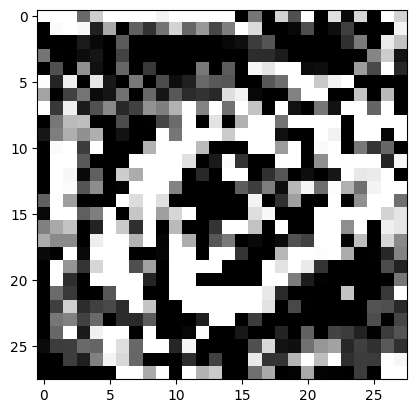

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 0


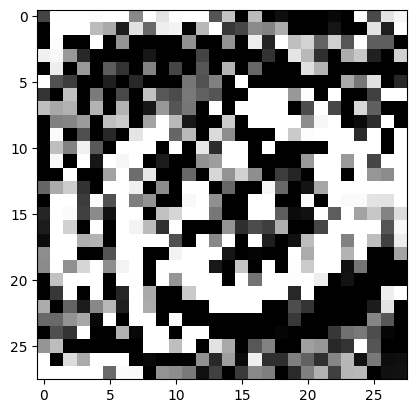

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 2


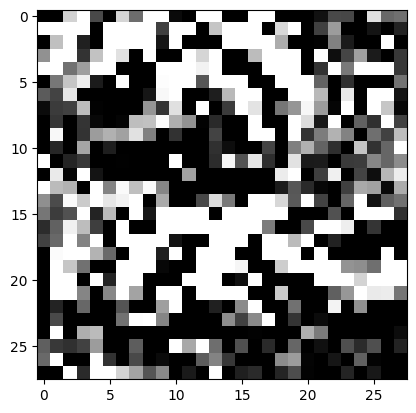

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 5


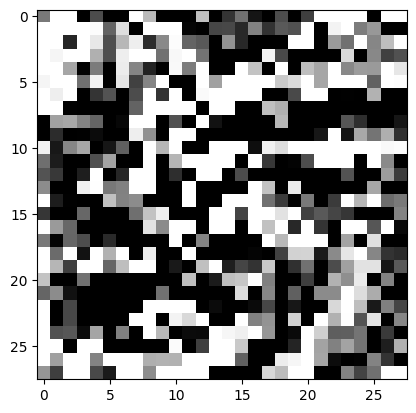

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 1


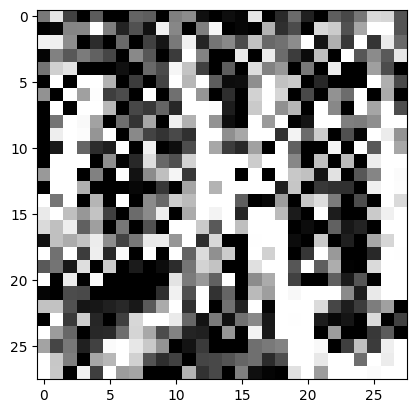

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 9


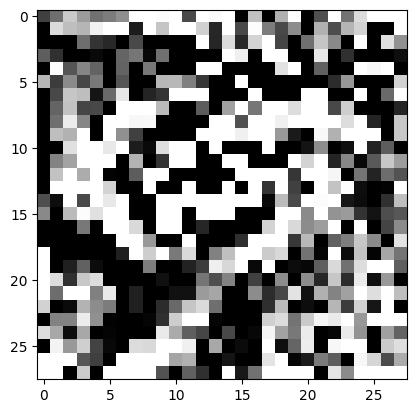

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 5


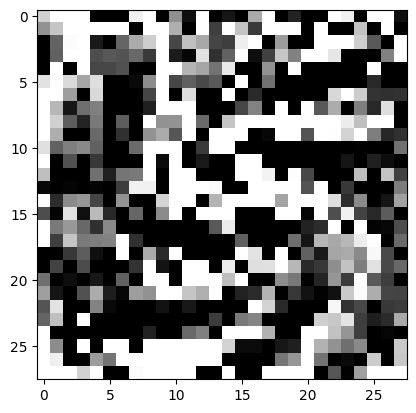

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 1


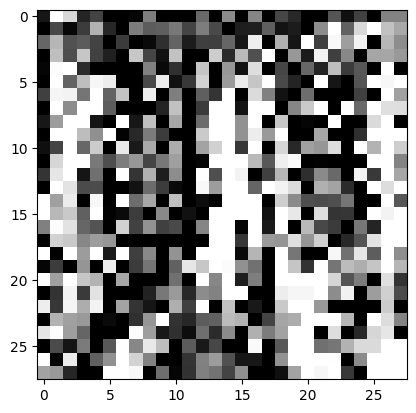

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 0


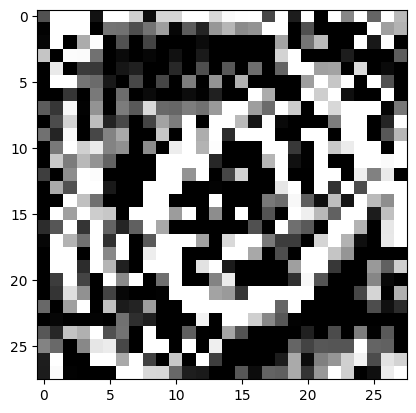

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 3


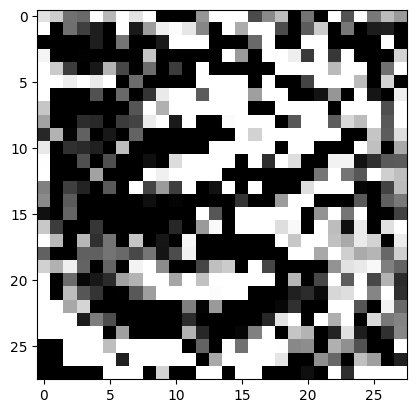

In [6]:

for i, (batch_data, batch_label) in enumerate(sample_dataloader):

    print(batch_data.shape), print(batch_label.shape)

    rand_idx = 2
    print(f"the label is {batch_label[rand_idx]}")
    visualize_image(batch_data[rand_idx])

    
# data_l = data_l.unsqueeze(0)
# output = model(data_l)
# data_l.shape, print(output), output.shape
    

In [65]:
from train import test_model
from utils import get_logger

logger = get_logger("logs")

def unpack_dataloader(data_loader):
    """change the shape of the data loader from 10 x 64 x img_shape to 640 x img_shape"""
    "return data loader"

    data = []
    labels = []

    for i, (d, l) in enumerate(data_loader):

        data.append(d)
        labels.append(l)

    """ change data from List of tensors to a single tensor that is the concatenation of the tensors"""


    data = torch.cat(data)
    data = data.view(-1, *data.shape[2:])

    print(data.shape)

    
    labels = torch.cat(labels)
    # convert each value of labels to 64 values

    labels = labels.repeat(64)
    print(labels.shape)
    

    return DataLoader(TensorDataset(data, labels), batch_size=64, shuffle=True)

sample_dataset = unpack_dataloader(sample_dataloader)
test_model(generator.model, sample_dataset, device, logger, model_config)

torch.Size([640, 28, 28])
torch.Size([40960])


AssertionError: Size mismatch between tensors

In [12]:
# res18mnist, trained =
# import os
# print(os.path.curdir)
model_config_dir = "configs/model_configs/ResNet18_MNIST.yaml"
model_config1 = load_config(model_config_dir)


image1 = torch.rand(32, 1, 28, 28)
# image1.shape
model1, t = load_model(model_config1, torch.device("cuda"))

model1(image1)

# trained

Model build as resnet18, pretrained: True, output channels: 10
Loading model from ./trained_models/ResNet18_MNIST.pth
Model loaded from ./trained_models/ResNet18_MNIST.pth


tensor([[ -1.0759,  -1.0002,   1.7754,   0.9550,  -3.2916,  -0.9564,  -3.4592,
           2.7722,  -0.1488,  -1.5632],
        [ -1.3871,  -2.2722,   0.2847,   0.4635,  -2.3006,  -2.1271,  -6.4316,
           5.0379,  -3.9110,   2.2982],
        [ -0.8139,  -1.3918,  -2.4930,  -1.0181,  -0.9492,   4.7967,   0.4596,
          -1.5574,  -1.2047,  -1.6944],
        [  1.4160,  -2.3102,   2.1292,  -1.3787,  -0.1696,  -2.1457,  -3.4218,
           2.4685,  -2.2912,  -0.0589],
        [  3.6905,   0.8090,   2.1424,  -1.3780,  -2.7229,  -2.9627,  -1.9441,
          -0.3368,   0.0678,  -2.8549],
        [ -0.9086,   2.0907,   3.5047,  -0.7963,   0.3548,  -3.3587,  -1.2824,
           0.3582,  -2.2192,  -2.9956],
        [ -2.8173,  -1.8814,  -5.3222,  -4.1239,   1.0306,   5.2410,   6.5485,
          -7.3088,  -1.5296,  -0.4710],
        [ -0.3334,   0.4692,   2.0075,   0.9493,  -2.0263,  -1.9701,  -1.5203,
           0.5659,  -1.3945,  -2.2239],
        [ -0.8927,   2.7841,  -3.3150,  -4.9243,

In [9]:

shape1 = [64,3,128,128]

torch.rand(1, *shape1).shape

torch.Size([1, 64, 3, 128, 128])